Task 1
If you were asked to build a model for predicting arousal and valence, using the provided audio
features as explanatory variables:

1. Which performance metrics would you use to evaluate your model’s predictions?

To evaluate our model’s performance given this would be a regression problem, we would use the metrics Mean Squared Error and Root Mean Squared Error for measuring the differences between the predicted and the actual values, the root of MSE expresses this error in the same units as the target variable, allowing for more intuitive interpretation. We would also make use of Median Absolute Error, which is similar to MSE and focuses on the median of the absolute errors, we included it as it aligns well with our goal of predicting the medians. Lastly we chose the R² score, as it tells us the proportion of variance in the predicted values explained by the model, indicating how well the model captures underlying patterns in the data.

2. Does the selection of the performance metric depend on the type of the response
variables? Explain your reasoning.

Yes, naturally different performance metrics are more accustomed to different responses, given if our response variable is regressive or catergorical would result in different performance metrics being used. For example we particularly chose Median Absolute Error when considering the response variable as it conceptually aligns with our predicted target. Especially for continous variables, regression metrics Mean Absolute Error and R² are well-suited for evaluating how accurately the continuous predictions approximate the actual values and insight into the model’s ability to capture the underlying variability.

On the other hand for the binarized versions of the response variables, where we classify arousal and valence into categories with only two possible outcomes [1], classification metrics such as Accuracy, Precision, Recall and F1-score are more appropriate. These metrics assess how effectively the model can distinguish between discrete categories rather than predicting exact numerical values[2].

3. Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you
use given that the objective is to build a predictive model able to generalise across
participants (i.e., make accurate predictions for unseen participants)? Justify your
choice.

For the validation protocol, it is essential to select an approach that ensures the predictive model can generalize to new, unseen participants. Given this we chose to implement a random participant holdout strategy, a cross-validation technique that aligns with our dataset. With it we exclude (hold out) the entire data of participants from the training data to be used exclusively for testing, this ensures that during the test set it mirrors a real-world scenario where the model, where we would be expected to predict arousal and valence levels for entirely new unseen participant. 

This approach would give us a strict separation between training and testing data at the participant level, preventing data leakage and overfitting that could occur if information from the same individual appeared in both sets. Other cross-validation techniques would simply discard the participant id and shuffle the data, this method is well suited for a dataset with subsequent participants.

Task 2 Using the provided audio features, build predictive models for arousal and valence:

1. Develop a predictive model for each response variable (arousal and valence) using
some or all of the provided audio features as explanatory variables

First we preprocessed the dataset using feature selection; separating the target variables, median_arousal and median_valence, from the feature set. These will serve as the outputs our models aim to predict and therefore they should not be included in the training dataset. We also excluded the Participant ID as this is a categorical identifier unique to each individual, including this as a feature would make sense for a regreseeive model.

We implemented random participant holdout as a validation technique, by randomly setting aside a subset of participants during model training. The Participant ID played a crucial role for implementing this as we could set aside participants in their entirity. With this method we could be sure that no data leakage could occur during training, if we simply split a participants recordings into a training and test sets the model may easily perform unrealisitically well (given it already has training knowledge regarding them), rather than a real life scenario where an unseen participant would need to be identified.

We then used the standard scaler to scale the data, naturally we didnt need to use Label Encoding or One-Hot Encoding as there are no catergorical values in the resulting dataset.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

df = pd.read_csv("project_data.csv")
scaler = StandardScaler()

y_arousal = pd.concat([df['Participant'], df['median_arousal']], axis=1)
y_valence = pd.concat([df['Participant'], df['median_valence']], axis=1)
df = df.drop(columns=['median_arousal', 'median_valence'])

# Get participant list
last_participant = df.iloc[[-1]]
participant_list = list(range(1, int(last_participant['Participant']) + 1))

# 80/20 test-train split
test_participants_index = random.sample(participant_list, 2)
train_participants_index = [item for item in participant_list if item not in test_participants_index]

x_test = pd.concat([df[df['Participant'] == index] for index in test_participants_index])
x_train = pd.concat([df[df['Participant'] == index] for index in train_participants_index])
y_test_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in test_participants_index])
y_test_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in test_participants_index])
y_train_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in train_participants_index])
y_trian_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in train_participants_index]) 

x_test = x_test.drop(columns=['Participant'])
x_train = x_train.drop(columns=['Participant'])
y_test_arousal = y_test_arousal.drop(columns=['Participant'])
y_test_valence = y_test_valence.drop(columns=['Participant'])
y_train_arousal = y_train_arousal.drop(columns=['Participant'])
y_trian_valence = y_trian_valence.drop(columns=['Participant'])

x_test_scaled = scaler.fit_transform(x_test)
x_train_scaled = scaler.fit_transform(x_train)

C:\Users\gianm\AppData\Local\Temp\ipykernel_202148\1980572450.py:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  participant_list = list(range(1, int(last_participant['Participant']) + 1))


The first task when selecticg a model is to identify if the problem is a regression or classification problem, given that we have to predict  the scaler values of median valence and arousal this is clearly a regression problem. Given this dataset presents a high-dimensionality problem, which traditional machine learning methods often struggle to handle, we made use of a regularization method Least Absolute Shrinkage and Selection Operator. Lasso regularization penalizes features to effectively exclude temselves by reducing them to zero, making it an ideal fit for this dataset.

In [ ]:
from sklearn.linear_model import LassoCV

lasso_cv_arousal = LassoCV(cv=10, random_state=0,max_iter=5000)
lasso_cv_arousal.fit(x_train_scaled, y_train_arousal.values.ravel())
selected_features_mask_arousal = lasso_cv_arousal.coef_ != 0
x_train_selected_arousal = x_train_scaled[:, selected_features_mask_arousal]
x_test_selected_arousal = x_test_scaled[:, selected_features_mask_arousal]

lasso_cv_valence = LassoCV(cv=10, random_state=0,max_iter=5000)
lasso_cv_valence.fit(x_train_scaled, y_trian_valence.values.ravel())
selected_features_mask_valence = lasso_cv_valence.coef_ != 0
x_train_selected_valence = x_train_scaled[:, selected_features_mask_valence]
x_test_selected_valence = x_test_scaled[:, selected_features_mask_valence]

For our model here we used Iterative Generalized Linear Models. Compared to other models like Random Forests and Support Vector Machines,  which often function as black-box models with limited transparency, Iterative GLMs provide explicit model coefficients that quantify the relationship between each input feature and the target variable, this makes them quite good for evaluation.

They are also more flexible and stable in handling different distributions, unlike Linear Regression, they can provide more reliable estimates in certain cases essential to this is the iterative fitting process. The iterative fitting process is inherent to GLMs, at each iteration, the algorithm recalculates weights for each observation based on how well the current model fits the data, essentially giving more importance to observations that align better with the model assumptions and less to those that do not. This ensures more reliable convergence to multicollinearity compared to simple linear regressio and particularly suited in a high-dimensional setting like ours, where the dataset contains features certainly correlate in one way or another.

In [5]:
import statsmodels.api as sm

x_train_glm_valence = sm.add_constant(x_train_selected_valence)
x_test_glm_valence = sm.add_constant(x_test_selected_valence)
x_train_glm_arousal = sm.add_constant(x_train_selected_arousal)
x_test_glm_arousal = sm.add_constant(x_test_selected_arousal)

glm_model_arousal = sm.GLM(y_train_arousal.values.ravel(), x_train_glm_arousal, family=sm.families.Gaussian())
glm_results_arousal = glm_model_arousal.fit()
glm_model_valence = sm.GLM(y_trian_valence.values.ravel(), x_train_glm_valence, family=sm.families.Gaussian())
glm_results_valence = glm_model_valence.fit()


glm_predictions_valence = glm_results_valence.predict(x_test_glm_valence)
glm_predictions_arousal = glm_results_arousal.predict(x_test_glm_arousal)

We then generated all the metrics discussed previously to evalutate the model. In the snippet below, we can see the previously discussed evaluation of the GLM model performance using the regression metrics. The snippet also outputs detailed summaries, providing insights into model coefficients and p-values (among others), allowing use to interpret and compare the predictive performance of the GLMs.

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np

glm_mse_valence = mean_squared_error(y_test_valence, glm_predictions_valence)
glm_mse_arousal = mean_squared_error(y_test_arousal, glm_predictions_arousal)
glm_rmse_valence =  np.sqrt(glm_mse_valence)
glm_rmse_arousal =  np.sqrt(glm_mse_arousal)
r2_valence = r2_score(y_test_valence, glm_predictions_valence)
r2_arousal = r2_score(y_test_arousal, glm_predictions_arousal)
medae_valence = median_absolute_error(y_test_valence, glm_predictions_valence)
medae_arousal = median_absolute_error(y_test_arousal, glm_predictions_arousal)

print(glm_results_arousal.summary())
print(f"\nGLM MSE (arousal): {glm_mse_arousal:.4f}")
print(f"\nGLM RMSE (arousal): {glm_rmse_arousal:.4f}")
print(f"\nGLM R^2 (arousal): {r2_arousal:.4f}")
print(f"\nGLM MedAE (arousal): {medae_arousal:.4f}")
print(glm_results_valence.summary())
print(f"\nGLM MSE (valence): {glm_mse_valence:.4f}")
print(f"\nGLM RMSE (valence): {glm_rmse_valence:.4f}")
print(f"\nGLM R^2 (valence): {r2_valence:.4f}")
print(f"\nGLM MedAE (valence): {medae_valence:.4f}")



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5774
Model:                            GLM   Df Residuals:                     5741
Model Family:                Gaussian   Df Model:                           32
Link Function:               Identity   Scale:                        0.023373
Method:                          IRLS   Log-Likelihood:                 2667.7
Date:                Fri, 06 Jun 2025   Deviance:                       134.18
Time:                        15:11:40   Pearson chi2:                     134.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3250
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0119      0.002     -5.900      0.0

From running the above multiple times we noticed that valence often generated with a negative R^2 score which suggests a level of underfitting in the features used. It should be known that when peforming LASSO for valence (in code below) the resulting feature set was always considerably smaller than that of arousal. In addition to this, valence always scores a better MSE and RMSE, this could be as theyre absolute measures unlike r^2 which is a relative measure that sees how the model performs versus a naive model that simply predicts the mean. We opted to be relatively skeptical of the r^2 value given it relativness to other values could cause it to swing drastically depending on the variables. Below we plotted the features selected by LASSO and their resulting coefficients.

The model summaries also highlight the explicit feature coefficients, revealing which audio features have a statistically significant effect on the predictions. With most of our p-values are low (effectively 0) meaning we can very confidently reject the null hypothesis that the coefficient is zero. This shows us that the GLMs consistently identify influential audio features and provide a transparent framework for understanding the feature relationship of our features and target.

Subsequently we indentify and plot the specific audio features that were selected by the LASSO regularization process. These selected features are then visualized using horizontal bar plots, where the magnitude and direction of each coefficient illustrate the feature’s impact on the respective target variable. This visual helps us understand which audio features play the most significant role in predicting emotional states, and shows how our inclusing of LASSO is an asset in high-dimensional modelling tasks.

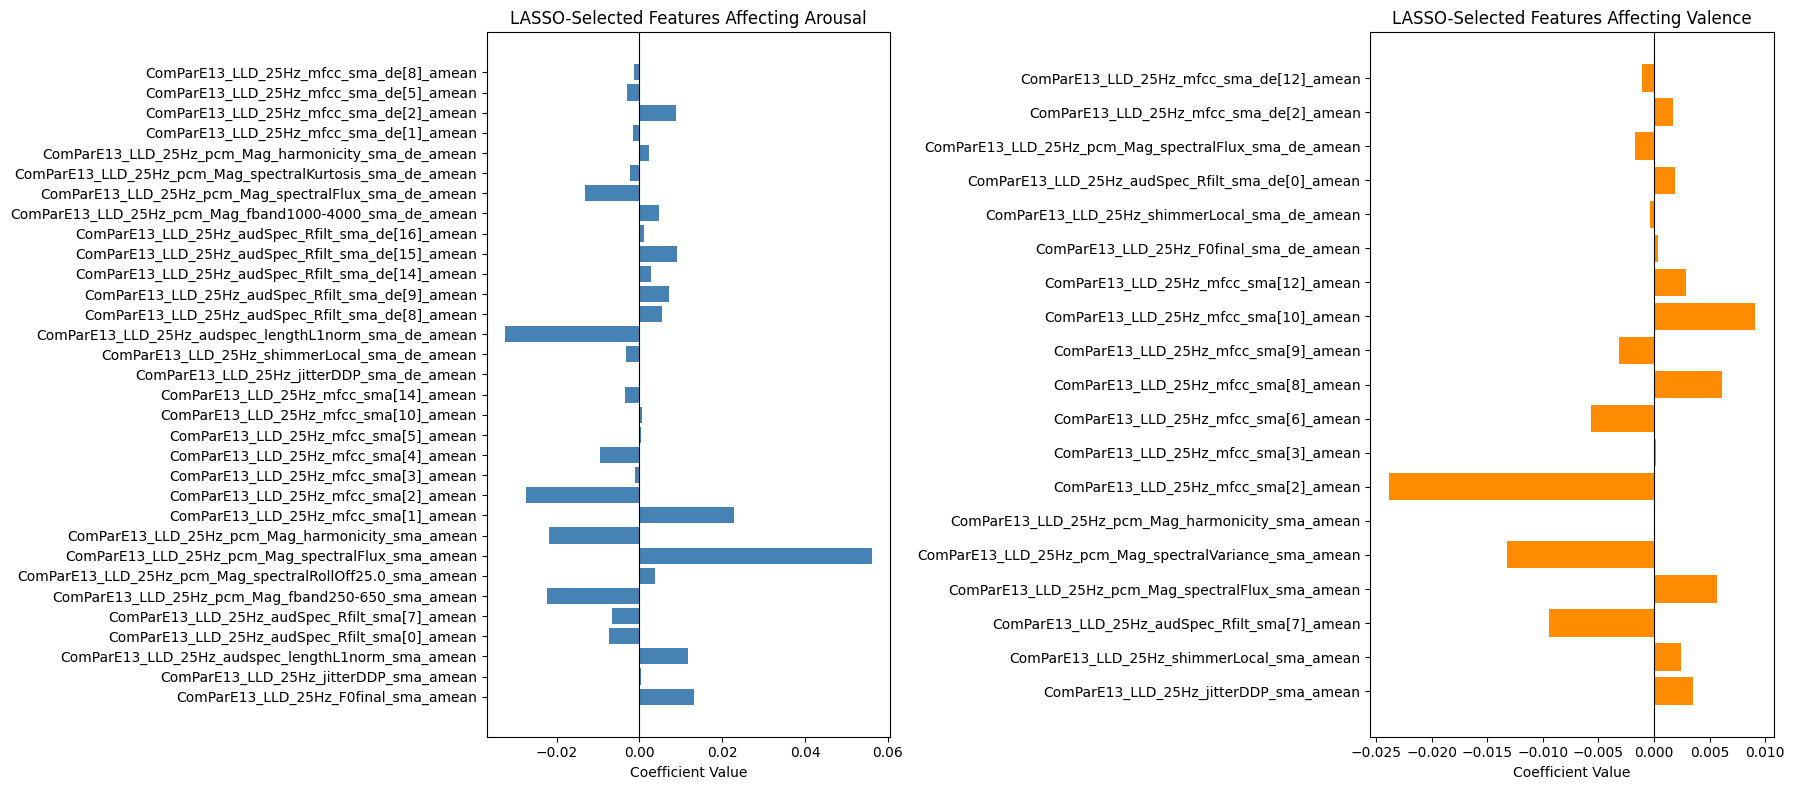

Number of Features used for Arousal: 32
Number of Features used for Valence: 19


In [7]:
import matplotlib.pyplot as plt
lasso_coef_arousal = lasso_cv_arousal.coef_
lasso_coef_valence = lasso_cv_valence.coef_
feature_names = x_train.columns
selected_features_arousal = np.array(feature_names)[lasso_coef_arousal != 0]
selected_coefs_arousal = lasso_coef_arousal[lasso_coef_arousal != 0]
selected_features_valence = np.array(feature_names)[lasso_coef_valence != 0]
selected_coefs_valence = lasso_coef_valence[lasso_coef_valence != 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)
axes[0].barh(selected_features_arousal, selected_coefs_arousal, color='steelblue')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title("LASSO-Selected Features Affecting Arousal")
axes[0].set_xlabel("Coefficient Value")
axes[1].barh(selected_features_valence, selected_coefs_valence, color='darkorange')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title("LASSO-Selected Features Affecting Valence")
axes[1].set_xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

print(f"Number of Features used for Arousal: {len(x_train_selected_arousal[0])}")
print(f"Number of Features used for Valence: {len(x_train_selected_valence[0])}")

1. Select and justify appropriate threshold values for binarizing both arousal and valence
annotations (the threshold for binarizing arousal should not necessarily be equal to the
threshold for binarizing valence). 

Our first step was to plot the distribution of the variables to see if anything may be discerned from them, we were curious if perhaps a multimodal distribution would appear. We also drew the lines of the mode, median and mean to discern the skew of the distributions. Included also is the lines of the for the percentiles, we used this to gauge what will be binarized if we use the percentiles as the threshold.

From this we discerned that both plots were unimodal with a right skew, with valence giving a prominent right distribution and arousal giving a more subtle one. 

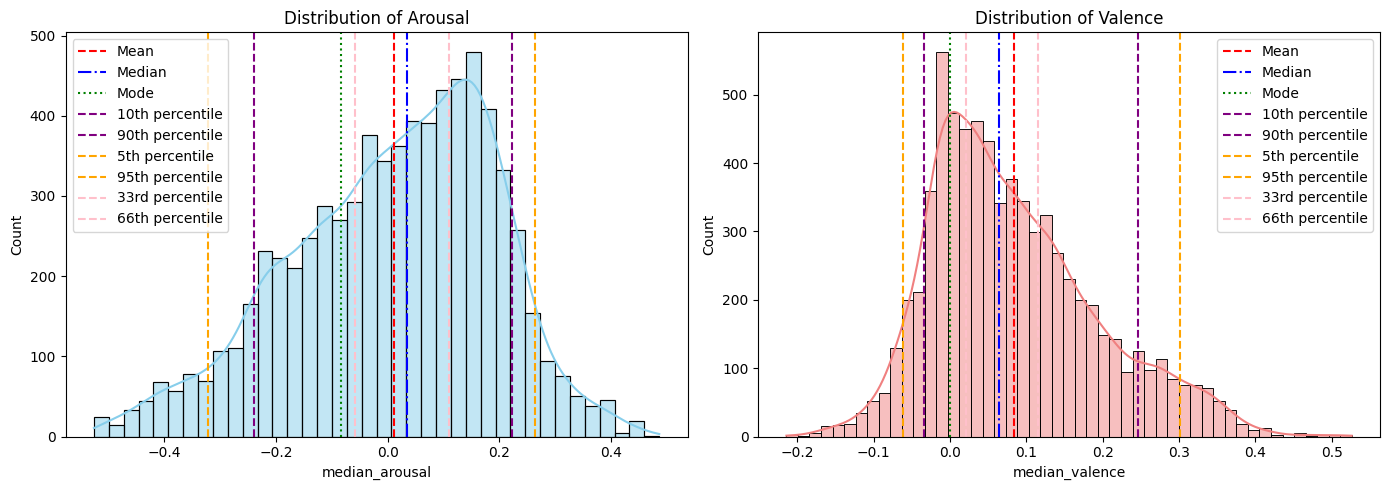

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

arousal_10 = np.percentile(y_arousal['median_arousal'], 10)
arousal_90 = np.percentile(y_arousal['median_arousal'], 90)
arousal_5 = np.percentile(y_arousal['median_arousal'], 5)
arousal_95 = np.percentile(y_arousal['median_arousal'], 95)
arousal_33 = np.percentile(y_arousal['median_arousal'], 33)
arousal_66 = np.percentile(y_arousal['median_arousal'], 66)
valence_10 = np.percentile(y_valence['median_valence'], 10)
valence_90 = np.percentile(y_valence['median_valence'], 90)
valence_5 = np.percentile(y_valence['median_valence'], 5)
valence_95 = np.percentile(y_valence['median_valence'], 95)
valence_33 = np.percentile(y_valence['median_valence'], 33)
valence_66 = np.percentile(y_valence['median_valence'], 66)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y_arousal['median_arousal'], kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(y_arousal['median_arousal'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(y_arousal['median_arousal'].median(), color='blue', linestyle='-.', label='Median')
axes[0].axvline(y_arousal['median_arousal'].mode().iloc[0], color='green', linestyle=':', label='Mode')
axes[0].axvline(arousal_10, color='purple', linestyle='--', label='10th percentile')
axes[0].axvline(arousal_90, color='purple', linestyle='--', label='90th percentile')
axes[0].axvline(arousal_5, color='orange', linestyle='--', label='5th percentile')
axes[0].axvline(arousal_95, color='orange', linestyle='--', label='95th percentile')
axes[0].axvline(arousal_33, color='pink', linestyle='--', label='33rd percentile')
axes[0].axvline(arousal_66, color='pink', linestyle='--', label='66th percentile')
axes[0].set_title("Distribution of Arousal")
axes[0].legend()
sns.histplot(y_valence['median_valence'], kde=True, ax=axes[1], color='lightcoral')
axes[1].axvline(y_valence['median_valence'].mean(), color='red', linestyle='--', label='Mean')
axes[1].axvline(y_valence['median_valence'].median(), color='blue', linestyle='-.', label='Median')
axes[1].axvline(y_valence['median_valence'].mode().iloc[0], color='green', linestyle=':', label='Mode')
axes[1].axvline(valence_10, color='purple', linestyle='--', label='10th percentile')
axes[1].axvline(valence_90, color='purple', linestyle='--', label='90th percentile')
axes[1].axvline(valence_5, color='orange', linestyle='--', label='5th percentile')
axes[1].axvline(valence_95, color='orange', linestyle='--', label='95th percentile')
axes[1].axvline(valence_33, color='pink', linestyle='--', label='33rd percentile')
axes[1].axvline(valence_66, color='pink', linestyle='--', label='66th percentile')
axes[1].set_title("Distribution of Valence")
axes[1].legend()

plt.tight_layout()
plt.show()


We then went for a K-Means Clustering approach to see if we could descern anything from the data, unfortunately we could not realise anything from this data and wasen't of much aid.

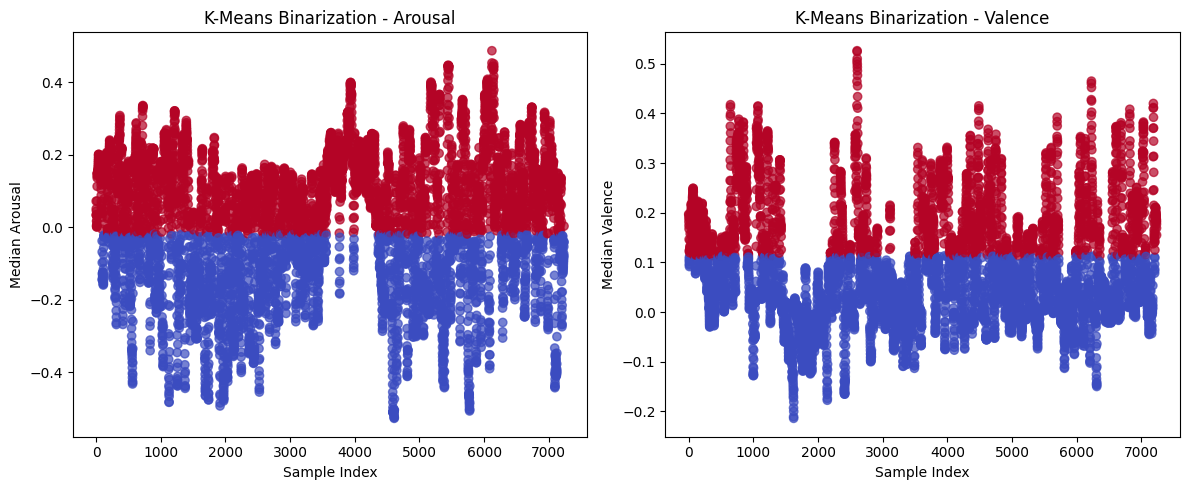

In [9]:
from sklearn.cluster import KMeans

arousal_values = y_arousal['median_arousal'].values.reshape(-1, 1)
valence_values = y_valence['median_valence'].values.reshape(-1, 1)
kmeans_arousal = KMeans(n_clusters=2, random_state=42).fit(arousal_values)
kmeans_valence = KMeans(n_clusters=2, random_state=42).fit(valence_values)

# Masked so 1 is the higher value
if kmeans_arousal.cluster_centers_[0] > kmeans_arousal.cluster_centers_[1]:
    kmeans_arousal.labels_ = 1 - kmeans_arousal.labels_
if kmeans_valence.cluster_centers_[0] > kmeans_valence.cluster_centers_[1]:
    kmeans_valence.labels_ = 1 - kmeans_valence.labels_

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(range(len(arousal_values)),y_arousal['median_arousal'], c=kmeans_arousal.labels_, cmap='coolwarm', alpha=0.7)
axes[0].set_title('K-Means Binarization - Arousal')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Median Arousal')
axes[1].scatter(range(len(valence_values)),y_valence['median_valence'], c=kmeans_valence.labels_, cmap='coolwarm', alpha=0.7)
axes[1].set_title('K-Means Binarization - Valence')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Median Valence')
plt.tight_layout()
plt.show()

We ultimately decided to set the theshold of binarization to the median of the distributions for perfectly balanced classes. We did attempt to use the pecentiles but decided that the significant class imbalance would not be optimal, during testing a larger imbalance often performed better as the model would overfit to simply predict the larger class.

In [10]:
# lower_pct = 5
# upper_pct = 95
# lower_pct = 10
# upper_pct = 90
y_arousal_median_threshold = y_arousal['median_arousal'].median()
y_arousal_valence_threshold = y_valence['median_valence'].median()

# arousal_lower_threshold = np.percentile(y_arousal['median_arousal'], lower_pct)
# arousal_upper_threshold = np.percentile(y_arousal['median_arousal'], upper_pct)
# valence_lower_threshold = np.percentile(y_valence['median_valence'], lower_pct)
# valence_upper_threshold = np.percentile(y_valence['median_valence'], upper_pct)

binarized_arousal = (y_arousal['median_arousal'] >= y_arousal_median_threshold).astype(int)
binarized_valence = (y_valence['median_valence'] >= y_arousal_valence_threshold).astype(int)

y_arousal_binarized = pd.concat([y_arousal['Participant'], binarized_arousal.rename('arousal_bin')], axis=1)
y_valence_binarized = pd.concat([y_valence['Participant'], binarized_valence.rename('valence_bin')], axis=1)

y_test_arousal_binarized = pd.concat([y_arousal_binarized[y_arousal_binarized['Participant'] == index] for index in test_participants_index]).drop(columns=['Participant'])
y_test_valence_binarized = pd.concat([y_valence_binarized[y_valence_binarized['Participant'] == index] for index in test_participants_index]).drop(columns=['Participant'])
y_train_arousal_binarized = pd.concat([y_arousal_binarized[y_arousal_binarized['Participant'] == index] for index in train_participants_index]).drop(columns=['Participant'])
y_train_valence_binarized = pd.concat([y_valence_binarized[y_valence_binarized['Participant'] == index] for index in train_participants_index]).drop(columns=['Participant'])

print("Test Arousal Binarized:")
print(y_test_arousal_binarized)
print("\nTrain Arousal Binarized:")
print(y_train_arousal_binarized)

Test Arousal Binarized:
      arousal_bin
3606            1
3607            1
3608            1
3609            1
3610            1
...           ...
1451            0
1452            0
1453            0
1454            0
1455            0

[1464 rows x 1 columns]

Train Arousal Binarized:
      arousal_bin
0               1
1               1
2               1
3               1
4               1
...           ...
7233            0
7234            0
7235            0
7236            0
7237            0

[5774 rows x 1 columns]


2. Implement a predictive model for each binarized response variable.

For this we decided on Support Vector Machines, given they were the most approriate linear classifier for high dimensional data because they are designed to find the optimal boundary that separates the two classes.

In [11]:
from sklearn.svm import SVC

svm_arousal_binarized = SVC(kernel='rbf', random_state=42)
svm_arousal_binarized.fit(x_train_selected_arousal, y_train_arousal_binarized.values)
svm_valence_binarized = SVC(kernel='rbf', random_state=42)
svm_valence_binarized.fit(x_train_selected_valence, y_train_arousal_binarized.values)

y_pred_svm_arousal = svm_arousal_binarized.predict(x_test_selected_arousal)
y_pred_svm_valence = svm_valence_binarized.predict(x_test_selected_valence)

c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3. Select appropriate metrics to evaluate the performance of the model in this scenario
using the validation protocol you proposed in Task 1.

We then evaluate the predictive performance of our SVM models using the previously discussed classification metrics being  Accuracy, Precision, Recall, and F1-Score. They provide insight into the model’s overall accuracy, its ability to avoid false positives and its effectiveness in identifying true positives with the F1-Score giving us a balanced metric. The overall performance of the classification metrics suggests that the SVM classifiers for both arousal and valence exhibit reasonably balanced predictive capability, demonstrating a moderate to strong ability to create meaningful distinctions between high and low states.

We also included the regression metrics to juxtapose, as noted previously choosing the proper performence metric given the target response is critical as they offer little practical insight in this context. For example, the R² scores for both arousal and valence are negative, indicating that these metrics are not meaningful here because they assess fit for continuous targets—not categorical classes. Similarly, the median absolute error either ends up being zero or one, reflecting the binary nature of the labels but ultimately failing to offer any nuanced understanding of the model’s classification accuracy or errors. Ultimately we included these regression metrics below to illustrate their inadequacy.

In [12]:
from sklearn.metrics import mean_squared_error,r2_score,median_absolute_error,accuracy_score,precision_score,recall_score,f1_score

svm_mse_valence = mean_squared_error(y_test_valence_binarized, y_pred_svm_valence)
svm_mse_arousal = mean_squared_error(y_test_arousal_binarized, y_pred_svm_arousal)
svm_rmse_valence =  np.sqrt(svm_mse_valence)
svm_rmse_arousal =  np.sqrt(svm_mse_arousal)
svm_r2_valence = r2_score(y_test_valence_binarized, y_pred_svm_valence)
svm_r2_arousal = r2_score(y_test_arousal_binarized, y_pred_svm_arousal)
svm_medae_valence = median_absolute_error(y_test_valence_binarized, y_pred_svm_valence)
svm_medae_arousal = median_absolute_error(y_test_arousal_binarized, y_pred_svm_arousal)

print(f"\nSVM Regression Metrics for Arousal:")
print(f"SVM MSE (arousal): {svm_mse_arousal:.4f}")
print(f"SVM RMSE (arousal): {svm_rmse_arousal:.4f}")
print(f"SVM R^2 (arousal): {svm_r2_arousal:.4f}")
print(f"SVM MedAE (arousal): {svm_medae_arousal:.4f}")

print(f"\nSVM Regression Metrics for Valence:")
print(f"SVM MSE (valence): {svm_mse_valence:.4f}")
print(f"SVM RMSE (valence): {svm_rmse_valence:.4f}")
print(f"SVM R^2 (valence): {svm_r2_valence:.4f}")
print(f"SVM MedAE (valence): {svm_medae_valence:.4f}")

svm_accuracy_arousal = accuracy_score(y_test_arousal_binarized, y_pred_svm_arousal)
svm_accuracy_valence = accuracy_score(y_test_valence_binarized, y_pred_svm_valence)
svm_precision_arousal = precision_score(y_test_arousal_binarized, y_pred_svm_arousal)
svm_precision_valence = precision_score(y_test_valence_binarized, y_pred_svm_valence)
svm_recall_arousal = recall_score(y_test_arousal_binarized, y_pred_svm_arousal)
svm_recall_valence = recall_score(y_test_valence_binarized, y_pred_svm_valence)
svm_f1_arousal = f1_score(y_test_arousal_binarized, y_pred_svm_arousal)
svm_f1_valence = f1_score(y_test_valence_binarized, y_pred_svm_valence)

print(f"\nSVM Classification Metrics for Arousal:")
print(f"Accuracy: {svm_accuracy_arousal:.4f}")
print(f"Precision: {svm_precision_arousal:.4f}")
print(f"Recall: {svm_recall_arousal:.4f}")
print(f"F1-Score: {svm_f1_arousal:.4f}")

print(f"\nSVM Classification Metrics for Valence:")
print(f"Accuracy: {svm_accuracy_valence:.4f}")
print(f"Precision: {svm_precision_valence:.4f}")
print(f"Recall: {svm_recall_valence:.4f}")
print(f"F1-Score: {svm_f1_valence:.4f}")



SVM Regression Metrics for Arousal:
SVM MSE (arousal): 0.3893
SVM RMSE (arousal): 0.6240
SVM R^2 (arousal): -1.0727
SVM MedAE (arousal): 0.0000

SVM Regression Metrics for Valence:
SVM MSE (valence): 0.4454
SVM RMSE (valence): 0.6673
SVM R^2 (valence): -1.1185
SVM MedAE (valence): 0.0000

SVM Classification Metrics for Arousal:
Accuracy: 0.6107
Precision: 0.8939
Recall: 0.5451
F1-Score: 0.6772

SVM Classification Metrics for Valence:
Accuracy: 0.5546
Precision: 0.7925
Recall: 0.4922
F1-Score: 0.6072


1. Select and justify appropriate threshold values for discretising (“high”, “neutral”,
“low”) both arousal and valence annotations (the threshold for discretising arousal should not necessarily be equal to the threshold for discretising valence).

To establish meaningful thresholds for this categorization, we leveraged the 33rd and 66th percentiles of the respective distributions, a common practice for partitioning data into roughly equal-sized groups that preserve the natural spread of the data. This method ensures that each category contains a balanced number of observations, which is particularly valuable for downstream ranking tasks that depend on capturing nuanced differences in emotional state intensity. We tested different percentiles for thresholding them, given our previous distribution plot containing a variaty of percentiles, but the resulting class imbalance proved to be detremental to learning. To provide a clear visual summary of the resulting class distributions, we plotted bar charts showing the counts of low, medium, and high categories for both arousal and valence. 

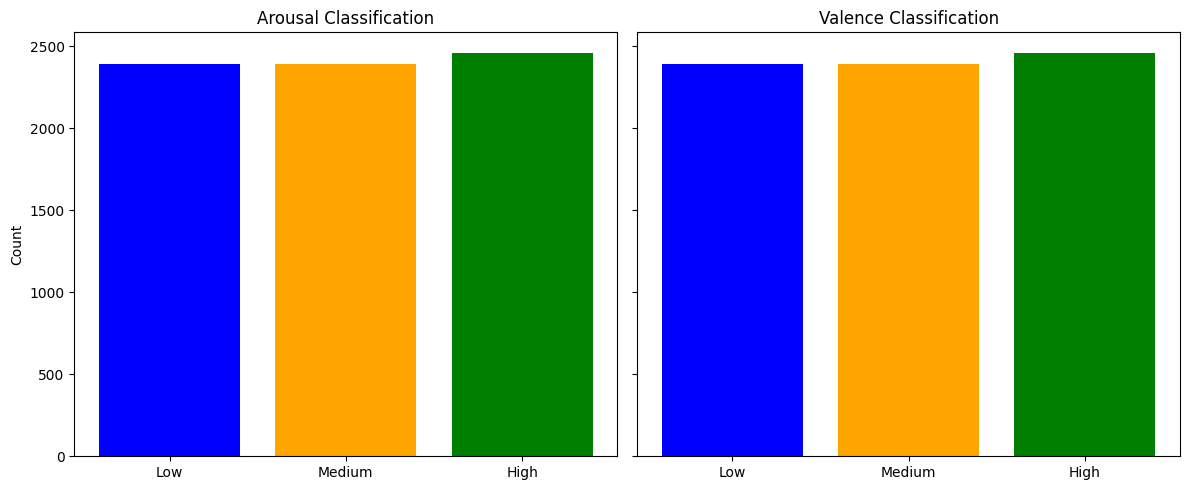

In [13]:
arousal_low_thresh = np.percentile(y_arousal['median_arousal'], 33)
arousal_high_thresh = np.percentile(y_arousal['median_arousal'], 66)
valence_low_thresh = np.percentile(y_valence['median_valence'], 33)
valence_high_thresh = np.percentile(y_valence['median_valence'], 66)


arousal_conditions = [ y_arousal['median_arousal'] <= arousal_low_thresh,y_arousal['median_arousal'] >= arousal_high_thresh]
ranked_arousal = np.select(arousal_conditions, [0, 2], default=1)
valence_conditions = [y_valence['median_valence'] <= valence_low_thresh,y_valence['median_valence'] >= valence_high_thresh]
ranked_valence = np.select(valence_conditions, [0, 2], default=1)

y_arousal_ranked = pd.concat([y_arousal['Participant'], pd.Series(ranked_arousal, name='arousal_rank')], axis=1)
y_valence_ranked = pd.concat([y_valence['Participant'], pd.Series(ranked_valence, name='valence_rank')], axis=1)
y_test_arousal_ranked = pd.concat([y_arousal_ranked[y_arousal_ranked['Participant'] == index] for index in test_participants_index]).drop(columns=['Participant'])
y_train_arousal_ranked = pd.concat([y_arousal_ranked[y_arousal_ranked['Participant'] == index] for index in train_participants_index]).drop(columns=['Participant'])
y_test_valence_ranked = pd.concat([y_valence_ranked[y_valence_ranked['Participant'] == index] for index in test_participants_index]).drop(columns=['Participant'])
y_train_valence_ranked = pd.concat([y_valence_ranked[y_valence_ranked['Participant'] == index] for index in train_participants_index]).drop(columns=['Participant'])


fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].bar(
    ['Low', 'Medium', 'High'],
    [np.sum(ranked_arousal == 0), np.sum(ranked_arousal == 1), np.sum(ranked_arousal == 2)],
    color=['blue', 'orange', 'green']
)
axs[0].set_title('Arousal Classification')
axs[0].set_ylabel('Count')
axs[1].bar(
    ['Low', 'Medium', 'High'],
    [np.sum(ranked_valence == 0), np.sum(ranked_valence == 1), np.sum(ranked_valence == 2)],
    color=['blue', 'orange', 'green']
)
axs[1].set_title('Valence Classification')

plt.tight_layout()
plt.show()


High is slightly larger as it has the residual values of the classification.

2. Implement a ranking predictive model for each response variable.

We decided to use an ordinal regression model, as we jave adjacent catagorical states with sequential order (each category flows into the next one).

We decided to implement an ordinal regression model to handle the ranked labels. We decided on this model as it is specifically suitable for ordinal outcomes, explicitly accounting for the ordered nature of these classes (each category flows into the next one {low,medium,high}), rather than treating them as purely categorical and seperate. By doing so, it can produce predictions that better respect the inherent hierarchy in the classifications.

In [14]:
from mord import LogisticAT

ordinal_arousal_model = LogisticAT()
ordinal_arousal_model.fit(x_train_selected_arousal, y_train_arousal_ranked.values.ravel())
y_pred_ordinal_arousal = ordinal_arousal_model.predict(x_test_selected_arousal)
ordinal_valence_model = LogisticAT()
ordinal_valence_model.fit(x_train_selected_valence, y_train_valence_ranked.values.ravel())
y_pred_ordinal_valence = ordinal_valence_model.predict(x_test_selected_valence)

3. Select appropriate metrics to evaluate the performance of the models in this scenario
using the validation protocol you proposed in Task 1. 

We evaluated the performance of the ordinal logistic regression models using the same classification metrics discussed earlier: accuracy, precision, recall, and F1-score. Since the predictions are ordinal labels and classification-based, we did not include the regression-style metrics here, as discussd they do not provide meaningful insights into the quality of these ranked classifications.

In [15]:
# Classification metrics for the ordinal (ranked) predictions
ordinal_accuracy_arousal = accuracy_score(y_test_arousal_ranked, y_pred_ordinal_arousal)
ordinal_accuracy_valence = accuracy_score(y_test_valence_ranked, y_pred_ordinal_valence)
ordinal_precision_arousal = precision_score(y_test_arousal_ranked, y_pred_ordinal_arousal, average='weighted')
ordinal_precision_valence = precision_score(y_test_valence_ranked, y_pred_ordinal_valence, average='weighted')
ordinal_recall_arousal = recall_score(y_test_arousal_ranked, y_pred_ordinal_arousal, average='weighted')
ordinal_recall_valence = recall_score(y_test_valence_ranked, y_pred_ordinal_valence, average='weighted')
ordinal_f1_arousal = f1_score(y_test_arousal_ranked, y_pred_ordinal_arousal, average='weighted')
ordinal_f1_valence = f1_score(y_test_valence_ranked, y_pred_ordinal_valence, average='weighted')

# Print classification metrics
print(f"\nOrdinal Logistic Regression Metrics for Arousal:")
print(f"Accuracy: {ordinal_accuracy_arousal:.4f}")
print(f"Precision: {ordinal_precision_arousal:.4f}")
print(f"Recall: {ordinal_recall_arousal:.4f}")
print(f"F1-Score: {ordinal_f1_arousal:.4f}")

print(f"\nOrdinal Logistic Regression Metrics for Valence:")
print(f"Accuracy: {ordinal_accuracy_valence:.4f}")
print(f"Precision: {ordinal_precision_valence:.4f}")
print(f"Recall: {ordinal_recall_valence:.4f}")
print(f"F1-Score: {ordinal_f1_valence:.4f}")


Ordinal Logistic Regression Metrics for Arousal:
Accuracy: 0.3081
Precision: 0.6401
Recall: 0.3081
F1-Score: 0.2968

Ordinal Logistic Regression Metrics for Valence:
Accuracy: 0.3436
Precision: 0.6021
Recall: 0.3436
F1-Score: 0.2728


 Task 3 
 In  this  task,  you  will  identify  similar  observations  captured  from  the  first  participant 
(participant ID = 1). Complete the following steps: 

1. Create  groups  of  similar  observations  from  the  first  participant  by  proposing  and 
implementing two suitable algorithms. 

We created a subset of the dataset by selecting only participant 1's data, we subsequently dropped the partipants column as this data is uneccassary. We also removed the median_arousal and median_variance as this section is based on creating groups of similar observations (features) and these last two columns are annotations/scores.

In [16]:
df = pd.read_csv("project_data.csv")

participant_df = df[df["Participant"] == 1]
participant_df = participant_df.drop(columns=["Participant",'median_arousal', 'median_valence'])
participant_df_scaler = scaler.fit_transform(participant_df)

We decided to perform Principal Component Analysis (PCA),  a statistical technique used for dimensionality reduction while preserving as much information in the data as possible. It transforms the original features into a new set of uncorrelated variables called principal components, which are ordered by the amount of variance they capture from the data.  This allows for simplifying complex datasets, visualizing high-dimensional data, and improving the performance of machine learning models by removing noise and redundancy. This may help us in our clustering such as it did in [3], however if too many components are needed to capture sufficient variance, PCA may not be useful for dimensionality reduction, as was the case in your analysis.

After applying PCA, we were given the contribution of each feature to every principal component (PC). We then plotted both the individual and cumulative explained variance to evaluate how much of the dataset’s total variation could be captured by successive PCs. Since the first three PCs accounted for less than 60% of the variation, and only after including 14 principal components did we reach around 80% cumulative explained variance, it became evident that the variance was too evenly spread across many components. This indicated that no small subset of PCs could sufficiently capture the data’s structure without significant information loss. Therefore, PCA was not used for dimensionality reduction in this analysis, as it would have compromised the integrity of the clustering results by excluding too much relevant variance from the original features. Instead, the full feature set was retained to ensure that all meaningful patterns could be captured during clustering, it also assisted us in better comparing and contrasting the affect of the models on the original dataset.

C:\Users\gianm\AppData\Local\Temp\ipykernel_202148\1325894636.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(pc_labels_test, rotation=10, ha='right')


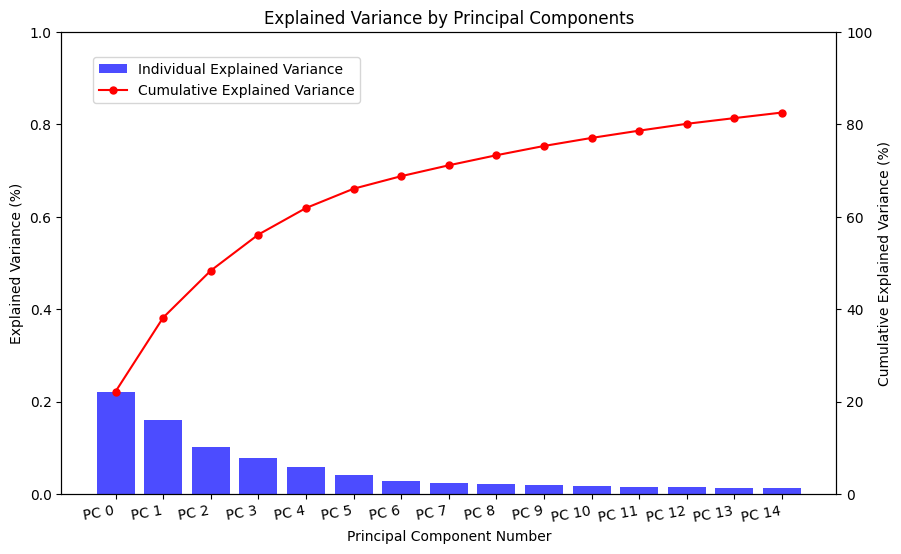

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
principal_components_test = pca.fit_transform(participant_df)

explained_variance = pca.explained_variance_ratio_

pc_labels_test = ['PC %s' % i for i in range(0, 15)]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(pc_labels_test, explained_variance, alpha=0.7, color='b', label='Individual Explained Variance')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_xlabel('Principal Component Number')
ax1.set_xticklabels(pc_labels_test, rotation=10, ha='right')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(pc_labels_test, explained_variance.cumsum()*100, 'ro-', label='Cumulative Explained Variance', markersize=5)
ax2.set_ylabel('Cumulative Explained Variance (%)')
ax2.set_ylim(0, 100)

plt.title('Explained Variance by Principal Components')
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))
plt.show()

For clustering we performed Hierarchical clustering using Ward's method to minimize the variance within the clusters and K-mediods with random initialization to further minimize the optimization criterion along with forward step wise assignment. It has been proven well suited to voice classification applications [6].

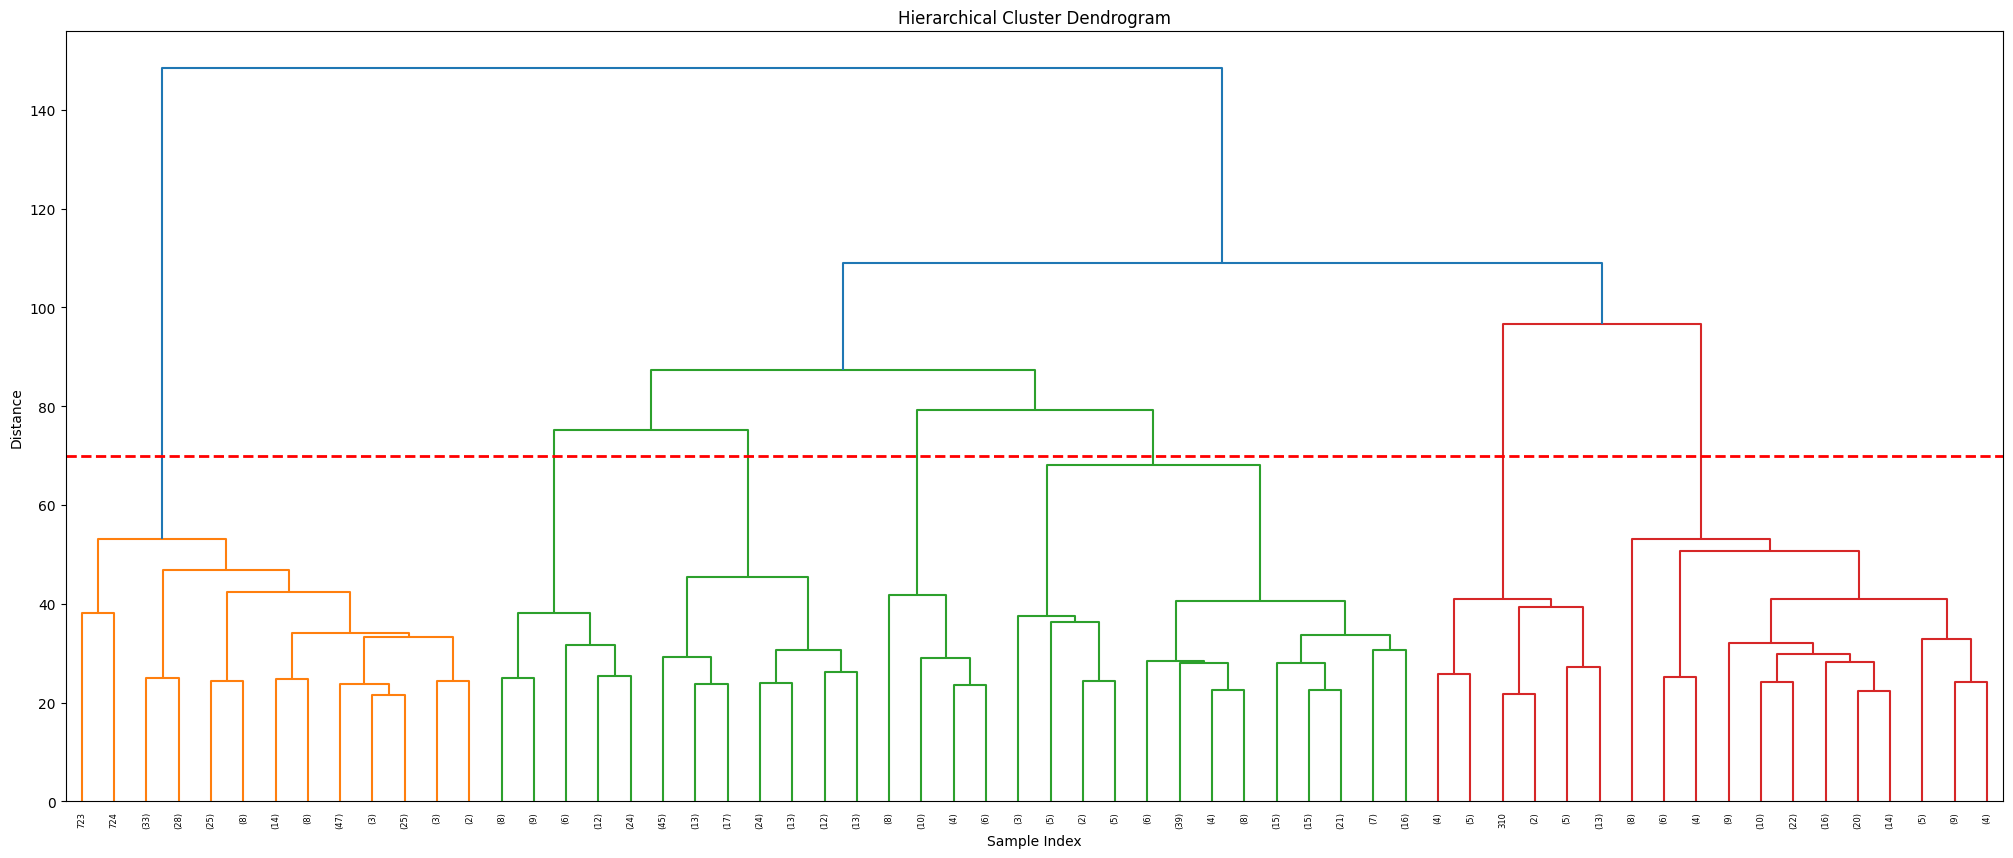

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(25,10))
link = linkage(participant_df_scaler,'ward')
dn = dendrogram(link,truncate_mode='lastp',p=60)
plt.axhline(y=70, color='red', linestyle='--', linewidth=2)
plt.title('Hierarchical Cluster Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

From this we can see at the 70 distance mark, shown by the dashed red line, around 7 clusters form. Hence we set the threshold for clustering to 7 clusters.

In [19]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
labels_hr = fcluster(link,t=7, criterion='maxclust')

Before implementing KMedoids we to determine the optimal number of clusters, the Elbow Method was employed by plotting the sum of distances between data points and their respective medoids across a range of cluster values (k = 2 to 10). This helped assess how compact the clusters were as the number of clusters increased. An elbow point (inflection point) is where the rate of improvement sharply drops—indicates a balance between model simplicity and clustering performance.

From the Elbow plot, a distinct inflection point can be observed at k = 4, a clear elbow where the improvement in compactness starts to diminish. Prior to this point, adding more clusters results in a significant drop in the sum of distances, meaning that the data is being partitioned more effectively. However, beyond k = 4, the rate of improvement flattens, indicating that additional clusters yield only marginal benefits. We also double checked this method by repeated testing and comparing silhoutte scores as k = 7 may have been also a contender but performed considerably worse in all metrics.

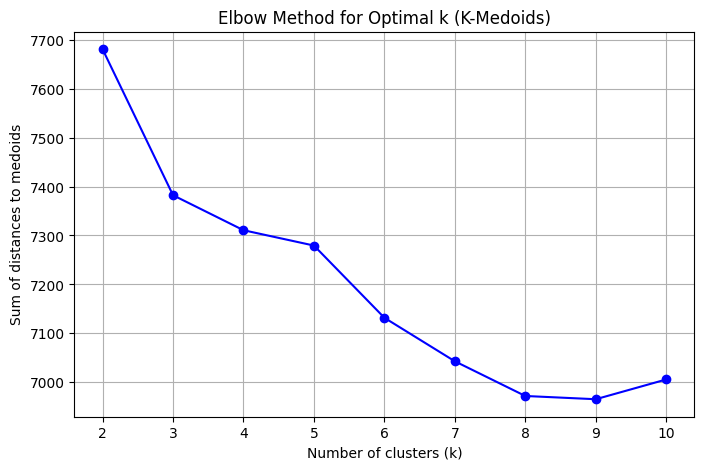

In [20]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

distortions = []
K = range(2, 11)

for k in K:
    kmedoids = KMedoids(n_clusters=k, random_state=42).fit(participant_df_scaler)
    labels = kmedoids.labels_
    medoids = participant_df_scaler[kmedoids.medoid_indices_]
    distance_matrix = pairwise_distances(participant_df_scaler, medoids)
    min_distances = np.min(distance_matrix, axis=1)
    distortions.append(np.sum(min_distances))

plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-', markersize=6)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of distances to medoids')
plt.title('Elbow Method for Optimal k (K-Medoids)')
plt.grid(True)
plt.show()

We then implemented K-Medoids clustering on the participant data to identify five representative clusters, it is more robust against outliers, unlike k-means which uses centroids, due to its use of medians [5]. To better visualize the results in a reduced feature space, we applied Principal Component Analysis (PCA) to project the high-dimensional data intoprincipal components to allow use to illustrate the data in 3D and 2D scatter plots. These plots show the cluster medoids which are highlighted with red large markers.

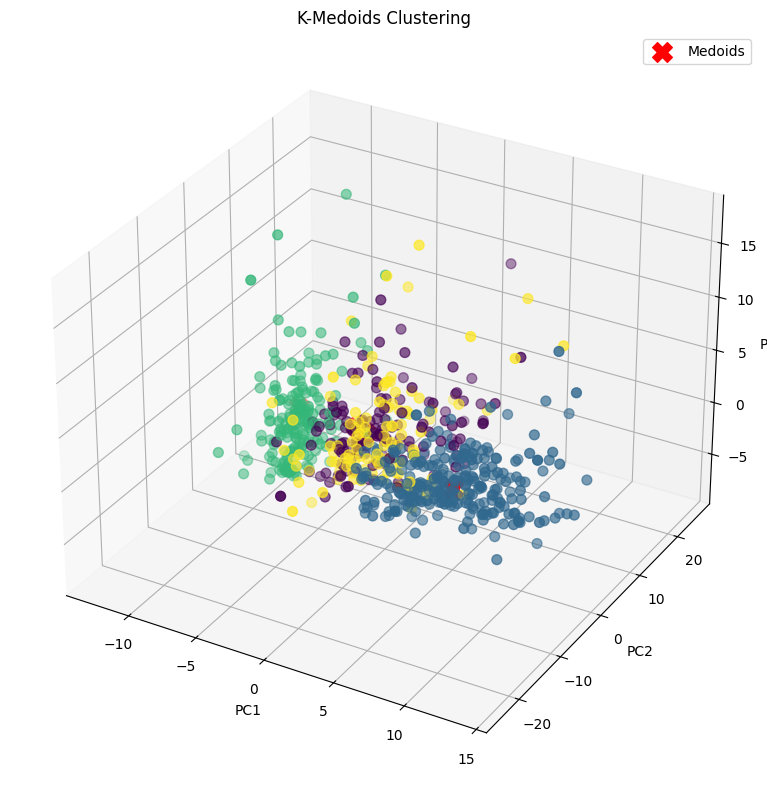

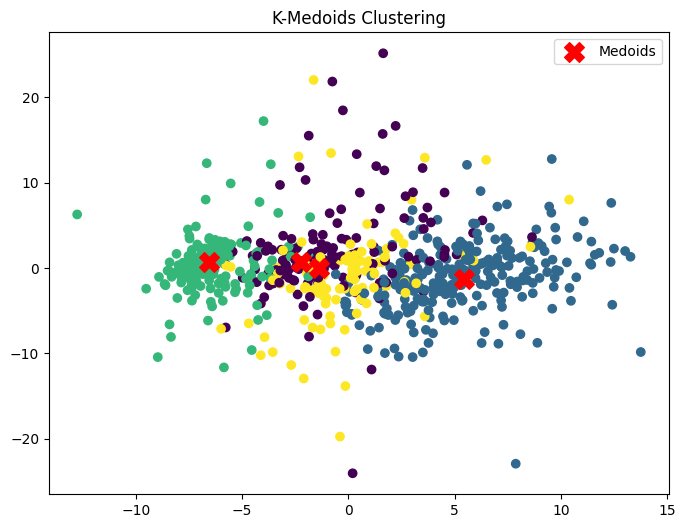

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


kmedoids = KMedoids(n_clusters=4, random_state=42)
labels_md = kmedoids.fit_predict(participant_df_scaler)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(participant_df_scaler)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_md, cmap='viridis', s=50)
ax.scatter(X_pca[kmedoids.medoid_indices_, 0],
           X_pca[kmedoids.medoid_indices_, 1],
           X_pca[kmedoids.medoid_indices_, 2],
           c='red', marker='X', s=200, label='Medoids')
ax.set_title('K-Medoids Clustering')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_md, cmap='viridis')
plt.scatter(X_pca[kmedoids.medoid_indices_, 0], X_pca[kmedoids.medoid_indices_, 1], c='red', marker='X', s=200, label='Medoids')
plt.title('K-Medoids Clustering')
plt.legend()
plt.show()

2. Evaluate the clusters quality using appropriate metrics. 

To assess the effectiveness of the hierarchical clustering and K-Medoids clustering models, we utilized the Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Score.The Silhouette Score measures how well each observation fits within its assigned cluster compared to other clusters, how tightly grouped points are within the same cluster and show distinctly different one cluster is from another. We observed that the Silhouette Scores for both methods were relatively low, suggesting that while there is some clustering structure present, it is not strongly defined.

We the applied the Davies-Bouldin Index to evaluate evaluates the similarity between each cluster and its most similar neighboring cluster with lower values implying greater separation between clusters and less overlap. In this metric hierarchical clustering generally produced a slightly lower index value.This was also true for the Calinski-Harabasz Score, which compares the dispersion of data points between clusters to the dispersion within clusters. Where hierarchical clustering scored higher as well indicating its clusters were both dense and well-separated

In [30]:
sil_score_hr = silhouette_score(participant_df_scaler, labels_hr)
db_score_hr = davies_bouldin_score(participant_df_scaler, labels_hr)
ch_score_hr = calinski_harabasz_score(participant_df_scaler, labels_hr)

print(f"\nHierarchical Clustering:")
print(f"Silhouette Score: {sil_score_hr:.3f}")
print(f"Davies-Bouldin Index: {db_score_hr:.3f}")
print(f"Calinski-Harabasz Score: {ch_score_hr:.3f}")


Hierarchical Clustering:
Silhouette Score: 0.081
Davies-Bouldin Index: 2.144
Calinski-Harabasz Score: 59.805


In [31]:
sil_score_md = silhouette_score(participant_df_scaler, labels_md)
db_score_md = davies_bouldin_score(participant_df_scaler, labels_md)
ch_score_md = calinski_harabasz_score(participant_df_scaler, labels_md)

print(f"\nK-Mediods Clustering:")
print(f"Silhouette Score: {sil_score_md:.3f}")
print(f"Davies-Bouldin Index: {db_score_md:.3f}")
print(f"Calinski-Harabasz Score: {ch_score_md:.3f}")


K-Mediods Clustering:
Silhouette Score: 0.077
Davies-Bouldin Index: 3.659
Calinski-Harabasz Score: 62.353


3. Compare the algorithms you implemented and select the best one.

When comparing the two clustering algorithms we implemented the best algorithim becomes evident, the hierarchical clustering using Ward’s method performed better overall in of our evaluation metrics. Both hierarchical clustering and K-medoids clustering show comparable performance. Hierarchical clustering achieves a slightly better silhouette score, indicating more cohesive clusters overall. Additionally, it has a notably lower Davies-Bouldin index, suggesting that the clusters are more distinct and well-separated compared to K-medoids. While K-medoids edges out hierarchical clustering in the Calinski-Harabasz score, this alone does not offset the weaker performance in the other two metrics. Therefore based on these metrics hierarchical clustering would be the preferred method here for more reliable and interpretable clusters.

Hierarchical clustering likely outperformed K-Medoids because it can naturally capture nested and progressive patterns present in spontaneous human behavior. Ward linkage minimizes intra-cluster variance, making it well-suited for high-dimensional affective data. Furthermore, hierarchical clustering does not rely on initial cluster centers, which can lead to more stable and interpretable results in this context.

5. How would you assign a new observation from the first participant to an existing group?

Since hierarchical clustering does not provide a direct way to classify new observations, we would need to train a classifier with the labels generated from clustering and have it predict the cluster of the new observaion.

On the other hand, a new participant can still be assigned to a K-Medoids cluster by calculating the distance between the new data point and each of the existing medoids, and assigning it to the nearest one based on a chosen distance metric such as Euclidean distance. This approach provides a practical method for categorizing new data using the existing clustering structure. However, it is important to note that K-Medoids does not support incremental updates. Therefore, while a new point can be associated with a cluster post calculations, the overall model will not adjust to reflect its inclusion. For the clusters to remain optimal, the K-Medoids algorithm would need to be retrained with the new data point included.

2.4. Task 4
Based on the results obtained from Task 3:

1. Explain whether the clustering information could be used to build more accurate models
for Task 2 and describe what you would do to build such models.

The clustering information we obtained, may be leveraged to build more accurate models for due to their ability to reveal unkown structures in the feaure space, potentially capturing local patterns that the standard regression or classification models might overlook [4].

We highlight one approach in particular to incorporate this information into new predictive models, being to treat the cluster assignments as an additional feature in the model. This would allow the model to differentiate between observations that come from different naturally occurring subgroups, helping to tailor predictions to the specific patterns within each cluster. These new categorical features could be easily incorporated into the existing SVM and GLM models making it easy to compare the affects with our baseline models.

Alternatively but in a similar vein, we could build separate predictive models for each cluster. This would involve splitting the dataset according to the cluster assignments and training individual models within each subgroup. We dont particularly endorse this approach as it leaves the possibility for data sparsity, meaning we have less datapoints than featurs. Despite this there are some advantages that arise from pooling all observations into a single, global model, such as reducing bias and variance.

# References

[1] Fergus, Paul, and Carl Chalmers. "Performance evaluation metrics." In Applied Deep Learning: Tools, Techniques, and Implementation, pp. 115-138. Cham: Springer International Publishing, 2022.


[2] De Diego, Isaac Martín, Ana R. Redondo, Rubén R. Fernández, Jorge Navarro, and Javier M. Moguerza. "General performance score for classification problems." Applied Intelligence 52, no. 10 (2022): 12049-12063.


[3] Ding, Chris, and Xiaofeng He. "Cluster structure of K-means clustering via principal component analysis." In Pacific-Asia Conference on Knowledge Discovery and Data Mining, pp. 414-418. Berlin, Heidelberg: Springer Berlin Heidelberg, 2004.


[4] Ezugwu, Absalom E., Abiodun M. Ikotun, Olaide O. Oyelade, Laith Abualigah, Jeffery O. Agushaka, Christopher I. Eke, and Andronicus A. Akinyelu. "A comprehensive survey of clustering algorithms: State-of-the-art machine learning applications, taxonomy, challenges, and future research prospects." Engineering Applications of Artificial Intelligence 110 (2022): 104743.

[5] Velmurugan, T. "Efficiency of k-means and k-medoids algorithms for clustering arbitrary data points." Int. J. Computer Technology & Applications 3, no. 5 (2012): 1758-1764.

[6] Fong, Simon. "Using hierarchical time series clustering algorithm and wavelet classifier for biometric voice classification." BioMed Research International 2012, no. 1 (2012): 215019.